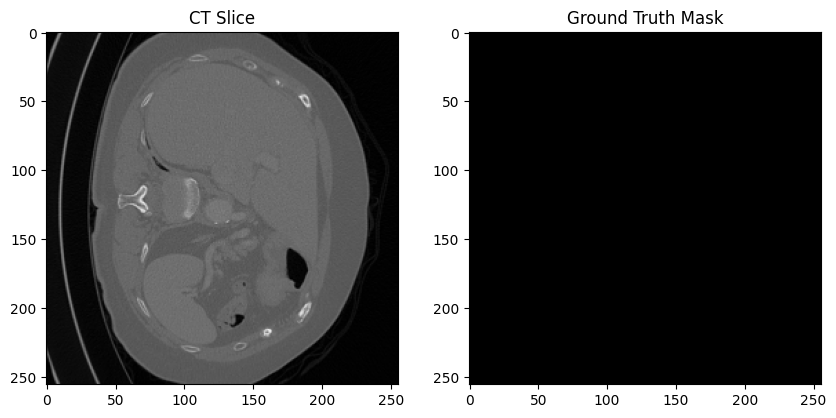

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

patient_id = "1"
data_dir = f"{patient_id}/data"
mask_dir = f"{patient_id}/masks"

data_files = sorted(os.listdir(data_dir))
mask_files = sorted(os.listdir(mask_dir))

data_path = os.path.join(data_dir, data_files[0])
mask_path = os.path.join(mask_dir, mask_files[0])

ct_slice = np.load(data_path)
mask_slice = np.load(mask_path)

# 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ct_slice, cmap="gray")
plt.title("CT Slice")

plt.subplot(1, 2, 2)
plt.imshow(mask_slice, cmap="gray")
plt.title("Ground Truth Mask")
plt.show()

In [2]:
from test_dsets import SegmentationTestDataset

ds = SegmentationTestDataset('./1')

nonzero_indices = []

for i in range(len(ds)):
    _, mask = ds[i]
    if mask.sum() > 0:
        nonzero_indices.append(i)

print(f" GT 마스크가 있는 슬라이스 수: {len(nonzero_indices)}")
print(f" 인덱스: {nonzero_indices}")

 GT 마스크가 있는 슬라이스 수: 18
 인덱스: [115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133]


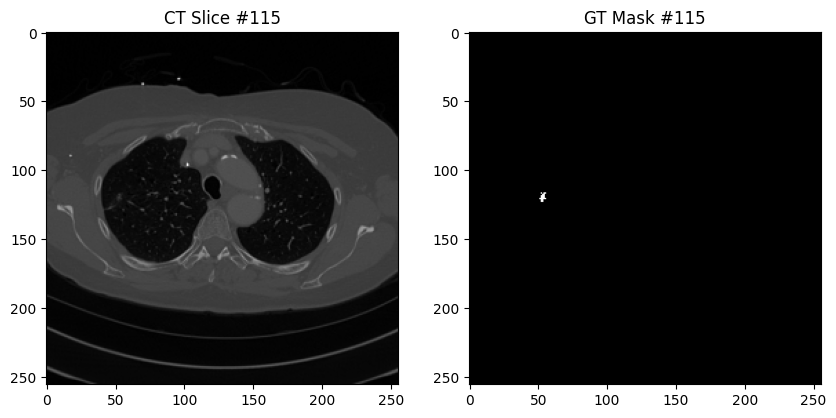

In [3]:
from test_dsets import SegmentationTestDataset
import matplotlib.pyplot as plt

# 환자 1번 기준
ds = SegmentationTestDataset('./1')

# 🔍 중앙 슬라이스 인덱스
center_idx = 115

# 중앙 슬라이스 불러오기
img_tensor, mask_tensor = ds[center_idx]

# 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_tensor[0], cmap='gray')
plt.title(f'CT Slice #{center_idx}')

plt.subplot(1, 2, 2)
plt.imshow(mask_tensor[0], cmap='gray')
plt.title(f'GT Mask #{center_idx}')

plt.show()

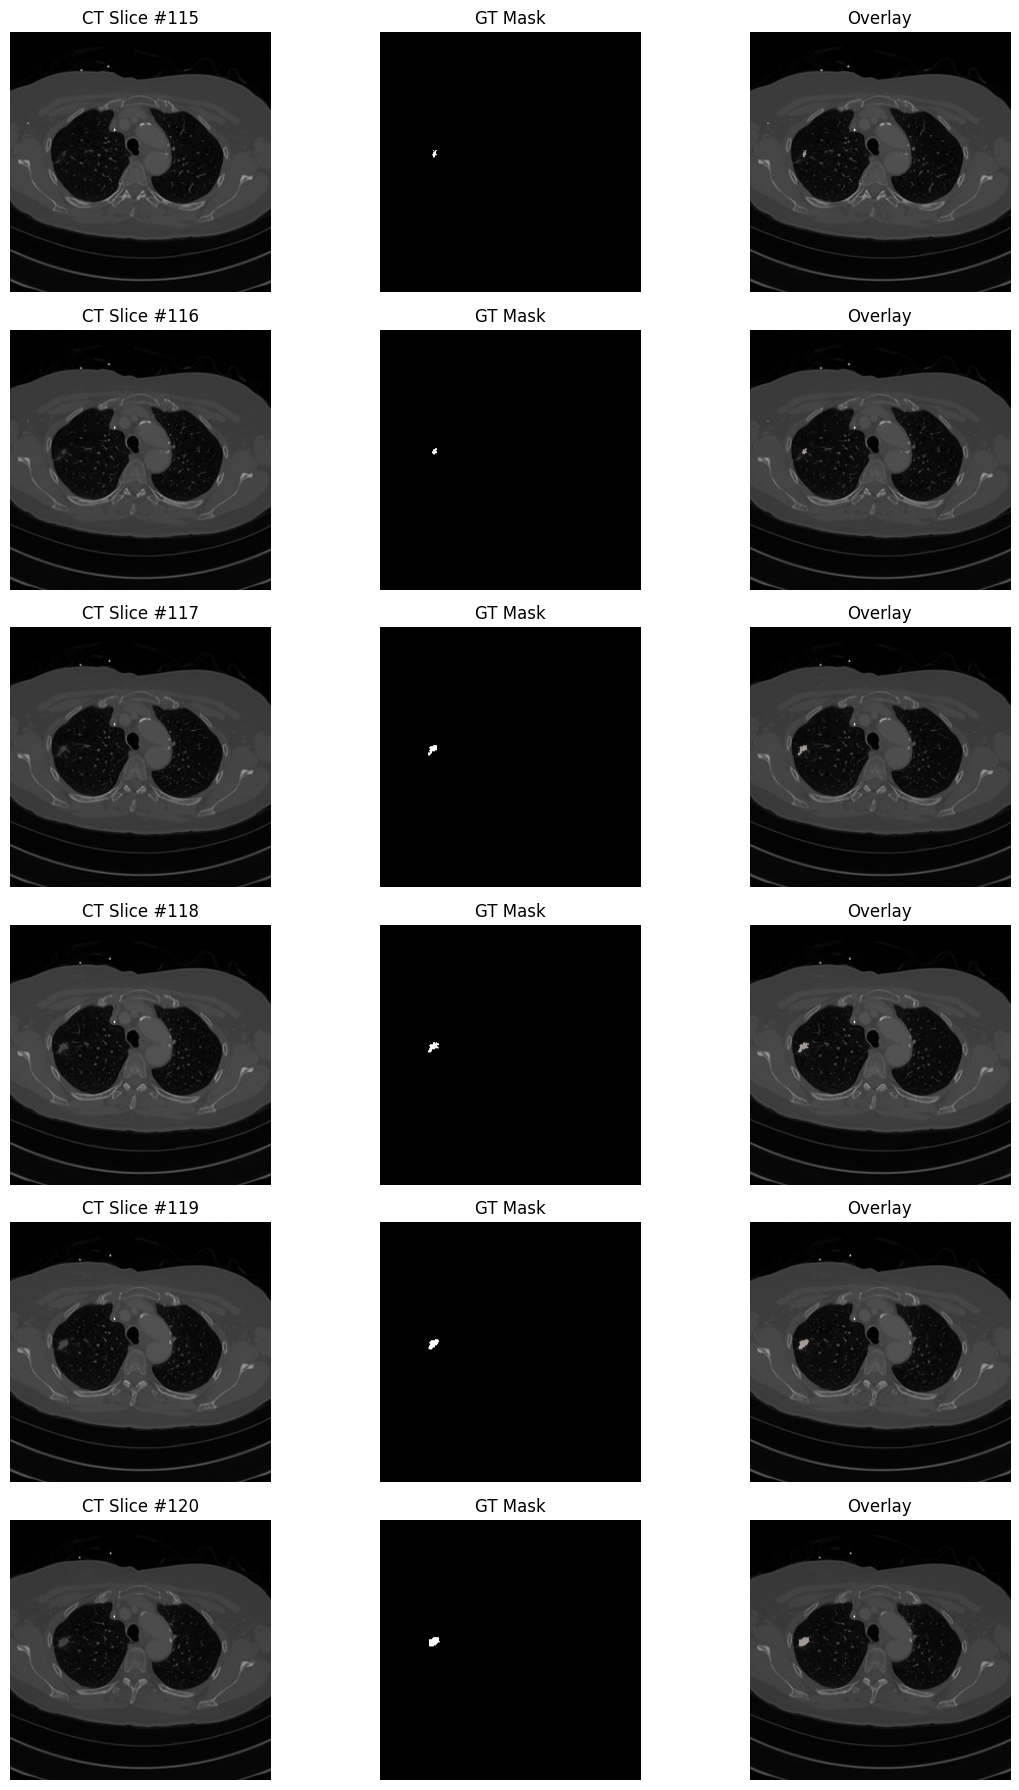

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 시각화할 GT 마스크 포함 슬라이스 인덱스 (원하면 전부 넣어도 됨)
nonzero_indices = [115, 116, 117, 118, 119, 120]

num_rows = len(nonzero_indices)
plt.figure(figsize=(12, 3 * num_rows))  # 3열 x N행 구성

for row_idx, idx in enumerate(nonzero_indices):
    img_tensor, mask_tensor = ds[idx]
    img = img_tensor[0].numpy()
    mask = mask_tensor[0].numpy()

    # 1️ 원본 CT
    plt.subplot(num_rows, 3, row_idx * 3 + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"CT Slice #{idx}")
    plt.axis('off')

    # 2️ GT 마스크
    plt.subplot(num_rows, 3, row_idx * 3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("GT Mask")
    plt.axis('off')

    # 3️ 오버레이 (CT + GT)
    plt.subplot(num_rows, 3, row_idx * 3 + 3)
    plt.imshow(img, cmap='gray')
    masked = np.ma.masked_where(mask == 0, mask)
    plt.imshow(masked, cmap='Reds', alpha=0.5)
    plt.title("Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()

torch.Size([7, 256, 256])


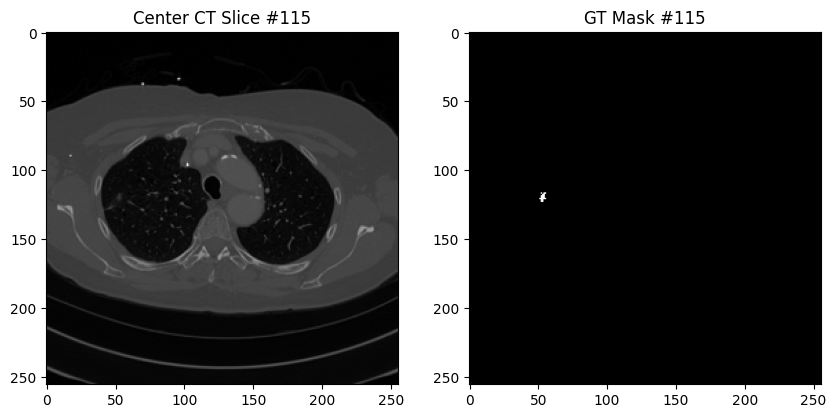

In [ ]:
from test_dsets import SegmentationTestStackedDataset

ds = SegmentationTestStackedDataset('./1')  # 7채널 stack
idx = 115
img_tensor, mask_tensor = ds[idx]
print(img_tensor.shape)  # [7, 256, 256]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_tensor[3], cmap='gray')
plt.title(f'Center CT Slice #{idx}')

plt.subplot(1, 2, 2)
plt.imshow(mask_tensor[0], cmap='gray')
plt.title(f'GT Mask #{idx}')
plt.show()

In [ ]:
ds = SegmentationTestStackedDataset('./1')
img_tensor, mask_tensor = ds[115]


print(img_tensor.shape)     # [7, 256, 256]
print(mask_tensor.shape)    # [1, 256, 256]

torch.Size([7, 256, 256])
torch.Size([1, 256, 256])


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11952\1271226008.py:42: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(true_mask, colors='red', linewidths=1, label='GT')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11952\1271226008.py:43: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(pred_mask, colors='blue', linewidths=1, label='Pred')


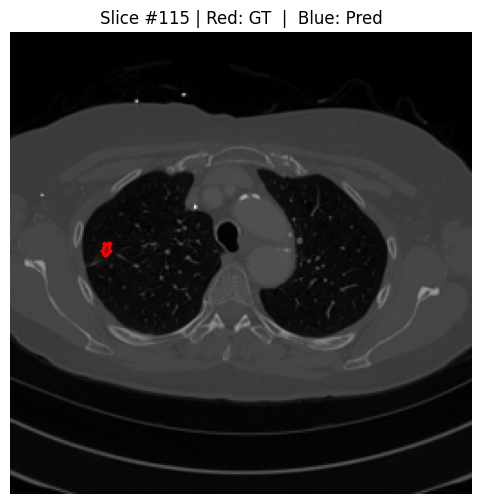

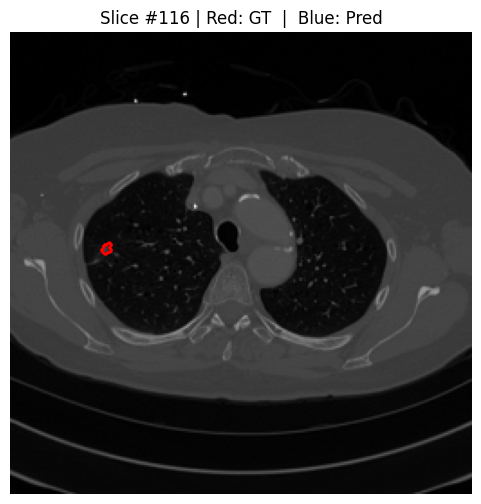

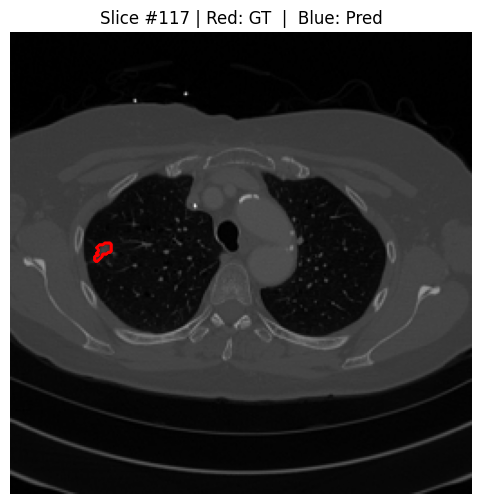

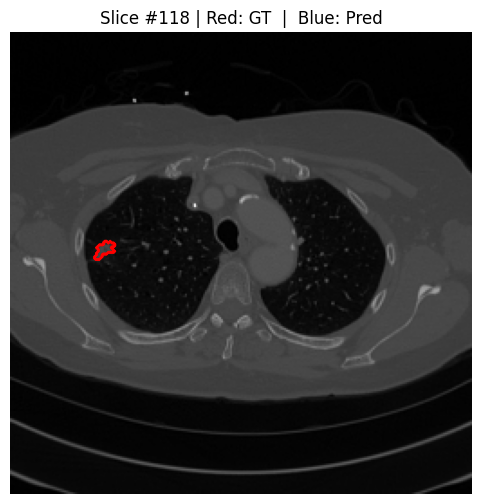

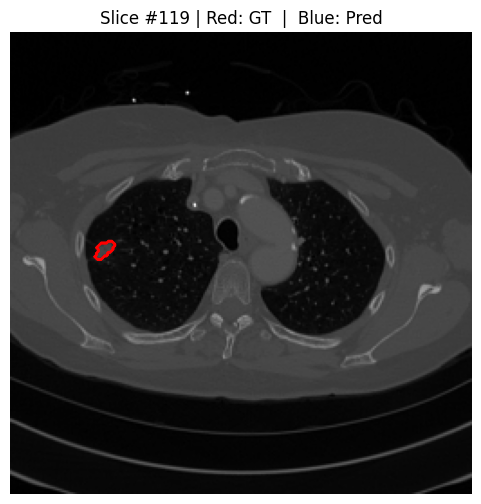

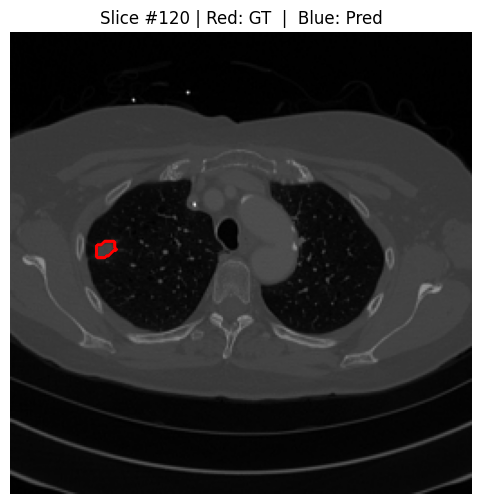

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))

from test_dsets import SegmentationTestStackedDataset
from p2ch13.model import UNetWrapper

# ─── 1. 모델 로드 ───
model = UNetWrapper(in_channels=7, n_classes=1, wf=4, depth=3, batch_norm=True)
model_path = "../data-unversioned/part2/models/p2ch13/seg_2025-07-18_09.54.37_my-final-run.9000000.state"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'], strict=True)
model = model.to(device)
model.eval()

# ─── 2. 데이터 로드 ───
ds = SegmentationTestStackedDataset('./1')
target_indices = [115, 116, 117, 118, 119, 120]

# ─── 3. 추론 + 시각화 ───
with torch.no_grad():
    for idx in target_indices:
        img_tensor, mask_tensor = ds[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)  # [1, 7, 256, 256]

        output = model(input_tensor)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = pred > 0.5

        # 중심 CT만 가져오기
        ct_slice = img_tensor[3].numpy()  # 중심 슬라이스 (index=3 in 7 stack)
        true_mask = mask_tensor[0].numpy()

        # 시각화
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(ct_slice, cmap='gray')
        ax.contour(true_mask, colors='red', linewidths=1, label='GT')
        ax.contour(pred_mask, colors='blue', linewidths=1, label='Pred')
        ax.set_title(f"Slice #{idx} | Red: GT  |  Blue: Pred")
        ax.axis('off')
        plt.show()

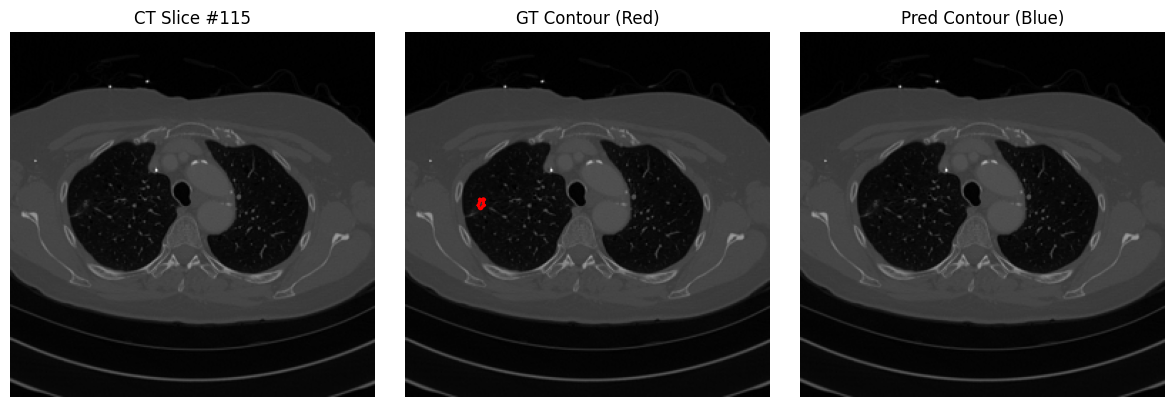

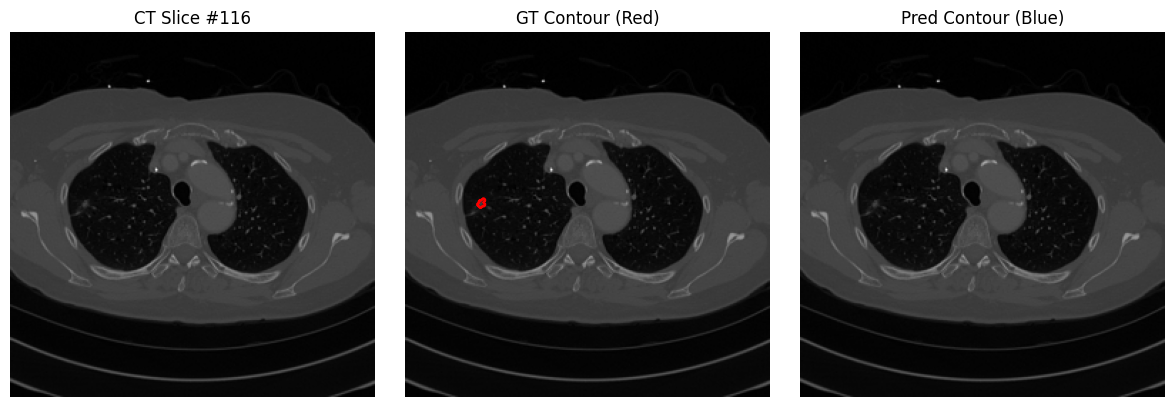

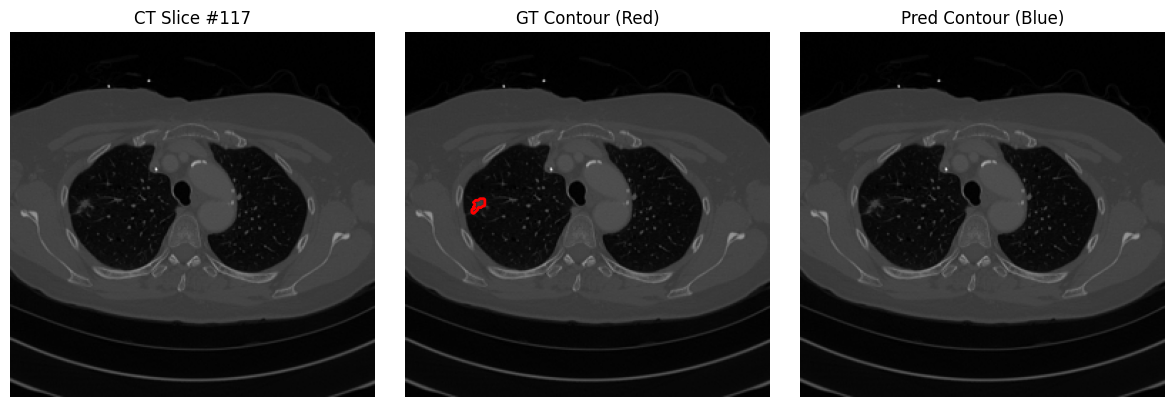

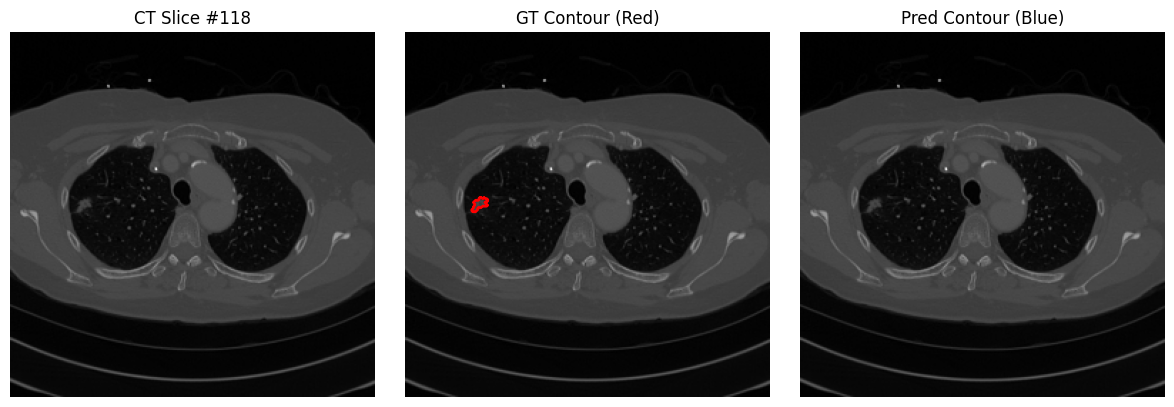

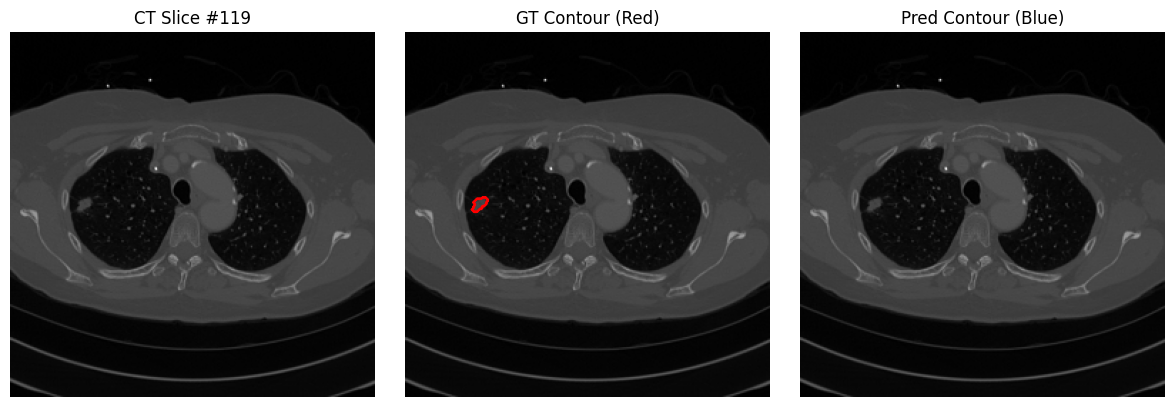

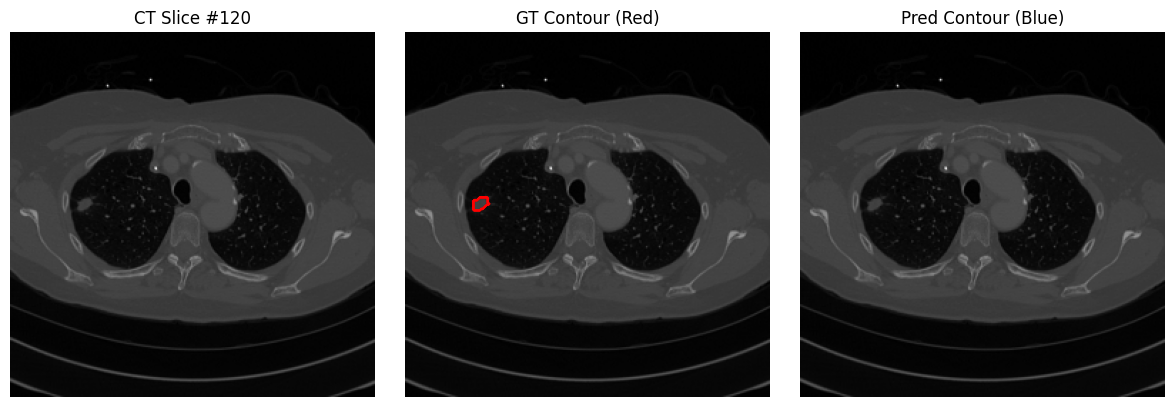

In [33]:
# ─── 1. 모델 로드 ───
model = UNetWrapper(in_channels=7, n_classes=1, wf=4, depth=3, batch_norm=True)
model_path = "../data-unversioned/part2/models/p2ch13/seg_2025-07-18_09.54.37_my-final-run.9000000.state"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'], strict=True)
model = model.to(device)
model.eval()

# ─── 2. 데이터 로드 ───
ds = SegmentationTestStackedDataset('./1')
target_indices = [115, 116, 117, 118, 119, 120]

# ─── 3. 추론 + 윤곽선 중심 시각화 ───
with torch.no_grad():
    for idx in target_indices:
        img_tensor, mask_tensor = ds[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)

        output = model(input_tensor)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = pred > 0.1

        ct_slice = img_tensor[3].numpy()       # 중심 CT
        true_mask = mask_tensor[0].numpy()     # GT

        # ─── 윤곽선 3장 한 줄 시각화 ───
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        # ① CT 원본
        axs[0].imshow(ct_slice, cmap='gray')
        axs[0].set_title(f"CT Slice #{idx}")
        axs[0].axis('off')

        # ② CT + GT 윤곽선 (빨강)
        axs[1].imshow(ct_slice, cmap='gray')
        axs[1].contour(true_mask, colors='red', linewidths=1)
        axs[1].set_title("GT Contour (Red)")
        axs[1].axis('off')

        # ③ CT + Pred 윤곽선 (파랑)
        axs[2].imshow(ct_slice, cmap='gray')
        axs[2].contour(pred_mask, colors='blue', linewidths=1)
        axs[2].set_title("Pred Contour (Blue)")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

Slice #120 | pred min: 0.50000, max: 0.50000, mean: 0.50000


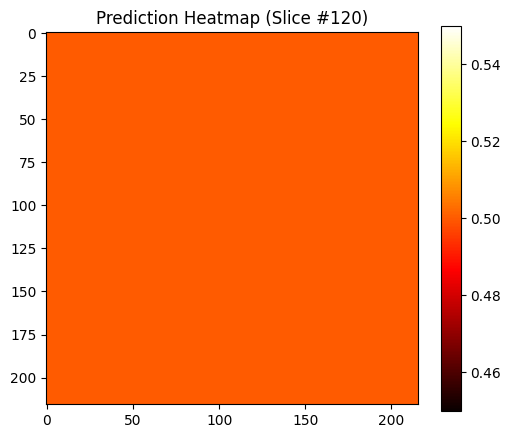

In [34]:
print(f"Slice #{idx} | pred min: {pred.min():.5f}, max: {pred.max():.5f}, mean: {pred.mean():.5f}")

plt.figure(figsize=(6, 5))
plt.imshow(pred, cmap='hot')
plt.title(f"Prediction Heatmap (Slice #{idx})")
plt.colorbar()
plt.show()


In [36]:
output = model(input_tensor)
print(output.min().item(), output.max().item(), output.mean().item())


4.2646118366827974e-16 4.529301467302155e-13 6.077849676452626e-14


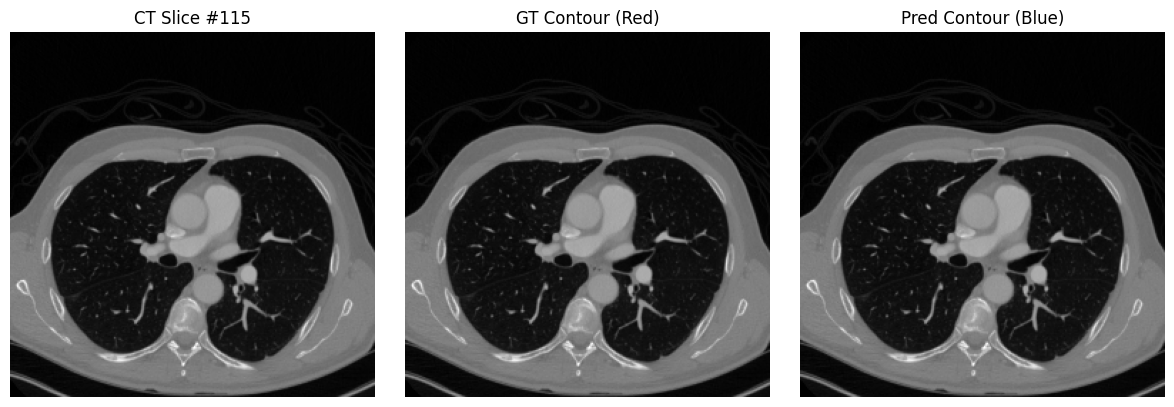

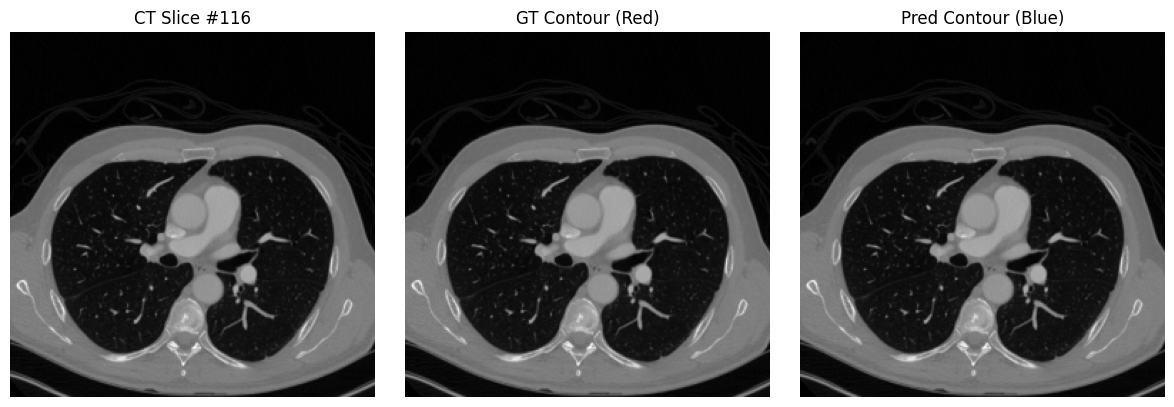

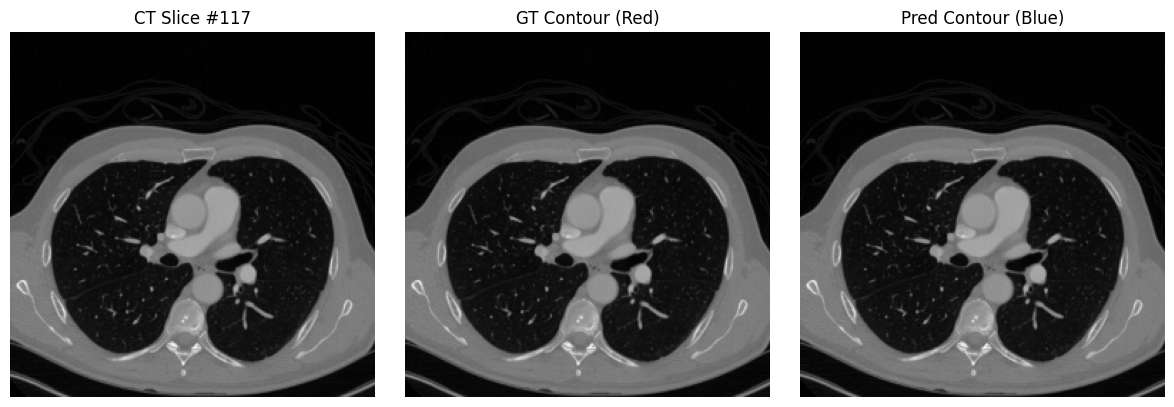

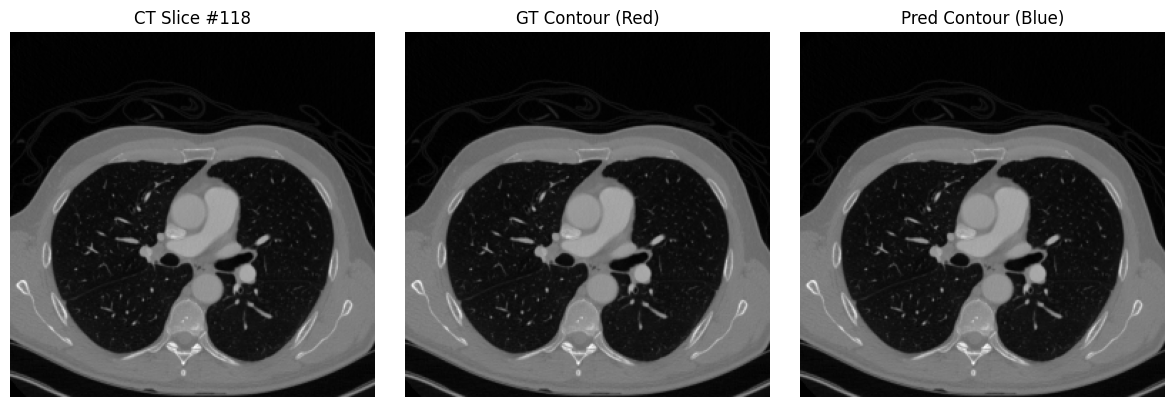

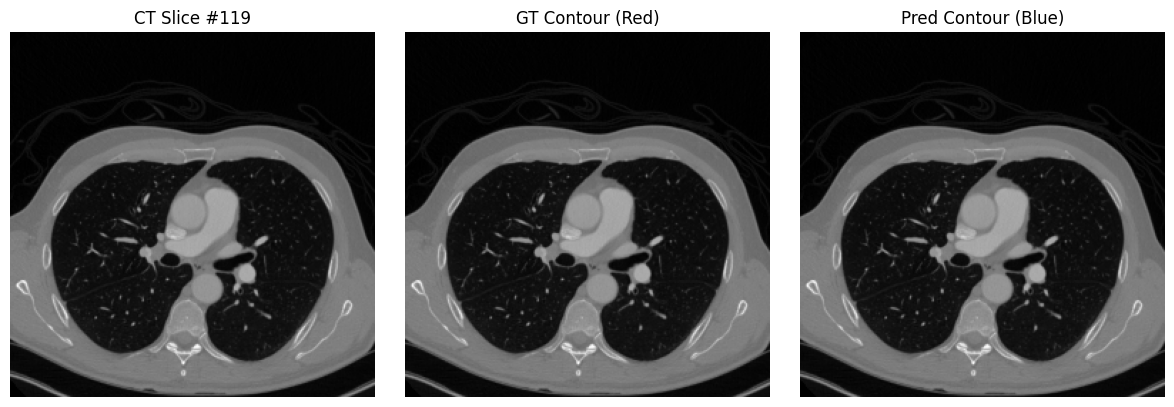

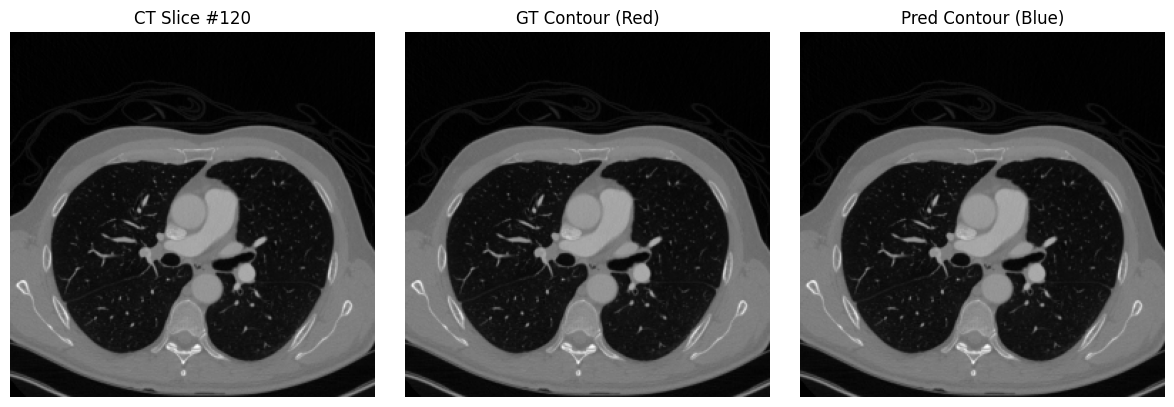

In [ ]:
# ─── 1. 모델 로드 ───
model = UNetWrapper(in_channels=7, n_classes=1, wf=4, depth=3, batch_norm=True)
model_path = "../data-unversioned/part2/models/p2ch13/seg_2025-07-18_09.54.37_my-final-run.9000000.state"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'], strict=False)
model = model.to(device)
model.eval()

# ─── 2. 데이터 로드 ───
ds = SegmentationTestStackedDataset('./2')
target_indices = [115, 116, 117, 118, 119, 120]

# ─── 3. 추론 + 윤곽선 중심 시각화 ───
with torch.no_grad():
    for idx in target_indices:
        img_tensor, mask_tensor = ds[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)

        output = model(input_tensor)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = pred > 0.1

        ct_slice = img_tensor[3].numpy()       # 중심 CT
        true_mask = mask_tensor[0].numpy()     # GT

        # ─── 윤곽선 3장 한 줄 시각화 ───
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        # ① CT 원본
        axs[0].imshow(ct_slice, cmap='gray')
        axs[0].set_title(f"CT Slice #{idx}")
        axs[0].axis('off')

        # ② CT + GT 윤곽선 (빨강)
        axs[1].imshow(ct_slice, cmap='gray')
        axs[1].contour(true_mask, colors='red', linewidths=1)
        axs[1].set_title("GT Contour (Red)")
        axs[1].axis('off')

        # ③ CT + Pred 윤곽선 (파랑)
        axs[2].imshow(ct_slice, cmap='gray')
        axs[2].contour(pred_mask, colors='blue', linewidths=1)
        axs[2].set_title("Pred Contour (Blue)")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()